In [1]:
# Imports for the file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#from sklearn.datasets import load_wine
from sklearn import tree
from sklearn import svm

In [2]:
# get and format the data
names_file = 'data/adult.names'
names = {}
cols = []
with open(names_file) as f:
    for line in f:
        if (line[0] != '|' and line[0] != '>'):
            d_line = line.strip()
            if (len(d_line)):
                ldata = d_line[:-1].split(': ')
                p_opt = []
                for opt in ldata[1].split(', '):
                    p_opt.append(opt)
                names[ldata[0]] = p_opt
                cols.append(ldata[0])

cols.append('cash')
names['cash'] = ['>50K', '<=50K']
df_train = pd.read_csv('data/adult.data', index_col=False, names=cols)
df_test = pd.read_csv('data/adult.test', index_col=False, names=cols)

# remove the first row on df_test (because it doesn't belong to the data)
if (df_test['age'][0] == '|1x3 Cross validator') :
    df_test.drop(0, inplace=True)

df_train = df_train.astype({
    'workclass': 'category',
    'education': 'category',
    'marital-status': 'category',
    'occupation': 'category',
    'relationship': 'category',
    'race': 'category',
    'sex': 'category',
    'native-country': 'category',
    'cash': 'category'
})
df_test = df_test.astype({
    'workclass': 'category',
    'education': 'category',
    'marital-status': 'category',
    'occupation': 'category',
    'relationship': 'category',
    'race': 'category',
    'sex': 'category',
    'native-country': 'category',
    'cash': 'category'
})

In [3]:
df_train.head(2)
df_test.head(2)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,cash
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.


SOME PRE-COMPUTATIONS

In [4]:
# creating an additional column to change <=50k to 0 and >50k to 1 in salary column
sal_cond = [
    (df_train['cash']==' <=50K'),
    (df_train['cash']==' >50K')
]
sal_vals = [0, 1]
df_train['slry_bool'] = np.select(sal_cond, sal_vals)
df_train.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,cash,slry_bool
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0


HOURS-PER-WEEK

In [5]:
col_name = 'hours-per-week'
col_counts = df_train[col_name].value_counts()
col_counts_keys = col_counts.keys().tolist()
col_counts_vals = col_counts.values.tolist()

print('Column counts:\n' + str(col_counts))
print('Minimum value: ' + str(min(df_train[col_name])))
print('Maximum value: ' + str(max(df_train[col_name])))
print('Mean value: ' + str(np.mean(df_train[col_name])))
print('Median value: ' + str(np.median(df_train[col_name])))
print('Mode value: ' + str(str(col_counts_keys[0])))

Column counts:
40    15217
50     2819
45     1824
60     1475
35     1297
      ...  
92        1
94        1
87        1
74        1
82        1
Name: hours-per-week, Length: 94, dtype: int64
Minimum value: 1
Maximum value: 99
Mean value: 40.437455852092995
Median value: 40.0
Mode value: 40


In [6]:
# create a copy of the original df_train
df_train_cpy = df_train.copy(deep=True)
# AGE: less than 50 as 0 and greater than 50 as 1
min_hpw = min(df_train['hours-per-week'])
max_hpw = max(df_train['hours-per-week'])
difference_point = 40
hpw_cond = [
    (df_train_cpy['hours-per-week']>=min_hpw) & (df_train_cpy['hours-per-week']<=difference_point),
    (df_train_cpy['hours-per-week']>difference_point) & (df_train_cpy['hours-per-week']<=max_hpw)
    ]
hpw_vals = ['['+str(min_hpw)+', '+str(difference_point)+']', '('+str(difference_point)+', '+str(max_hpw)+']']

# create a new column and use np.select to assign values to it using our lists as arguments
df_train_cpy['hpw_catgry'] = np.select(hpw_cond, hpw_vals)

# display updated DataFrame
df_train_cpy.head(2)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,cash,slry_bool,hpw_catgry
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0,"[1, 40]"
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0,"[1, 40]"


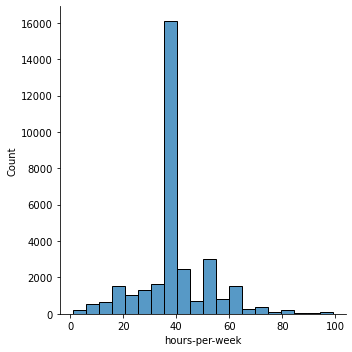

In [7]:
#HISTOGRAM
sns.displot(df_train_cpy, x='hours-per-week', bins=20)

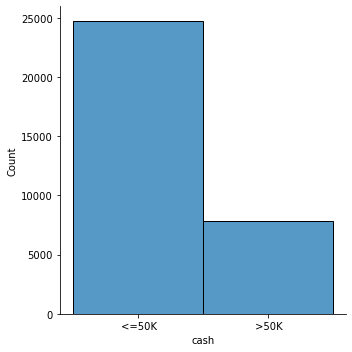

In [8]:
# SELECT ONLY PEOPLE WITH 40 hours per week
df_slct_hpw = df_train_cpy[(df_train_cpy['hours-per-week'] > 0) & (df_train_cpy['hours-per-week'] < 100)]
#df_slct_hpw = df_train_cpy[df_train_cpy['hours-per-week'] != 40]
sns.displot(df_slct_hpw, x='cash')

NATIVE-COUNTRY

In [9]:
col_name = 'native-country'
col_counts = df_train[col_name].value_counts()
col_counts_keys = col_counts.keys().tolist()
col_counts_vals = col_counts.values.tolist()

print('Column counts:\n' + str(col_counts))
print('Minimum count: ' + str(min(col_counts_vals)))
print('Maximum count: ' + str(max(col_counts_vals)))
print(len(col_counts_keys))

Column counts:
 United-States                 29170
 Mexico                          643
 ?                               583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                  

In [10]:
counts = df_train[col_name].value_counts()
filtered = counts[counts >= 100]
df_train_10_cntries = df_train[df_train[col_name].isin(filtered.index)]
df_train_10_cntries[col_name].value_counts()

 United-States                 29170
 Mexico                          643
 ?                               583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Dominican-Republic                0
 Ecuador                           0
 Hong                              0
 Cuba                              0
 China                             0
 France                            0
 Cambodia                          0
 Columbia                          0
 Greece                            0
 Guatemala                         0
 Haiti                             0
 Holand-Netherlands                0
 Honduras                          0
 England                           0
 Yugoslavia                        0
 Hungary                           0
 Vietnam                           0
 Trinadad&Tobago                   0
 

In [11]:
top_10_cntries = df_train[df_train[col_name]!=' ?'][col_name].value_counts()[:10].keys().tolist()
df_train_10_cntries = pd.DataFrame(df_train[ (df_train[col_name] == top_10_cntries[0]) |
          (df_train[col_name] == top_10_cntries[1]) |
          (df_train[col_name] == top_10_cntries[2]) |
          (df_train[col_name] == top_10_cntries[3]) |
          (df_train[col_name] == top_10_cntries[4]) |
          (df_train[col_name] == top_10_cntries[5]) |
          (df_train[col_name] == top_10_cntries[6]) |
          (df_train[col_name] == top_10_cntries[7]) |
          (df_train[col_name] == top_10_cntries[8]) |
          (df_train[col_name] == top_10_cntries[9]) ])

C:\Users\abhis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


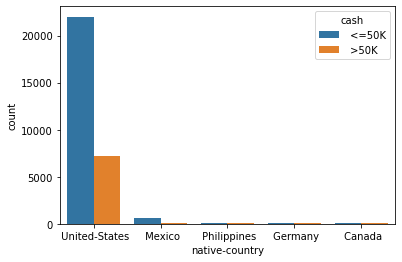

In [12]:
df_train_known = df_train[df_train[col_name] != ' ?']
labels_array = df_train_known[col_name]
sns.countplot(labels_array, order=pd.value_counts(labels_array).iloc[:5].index, data=df_train_known, hue='cash')
plt.savefig('with_us_nat_cntry.png')

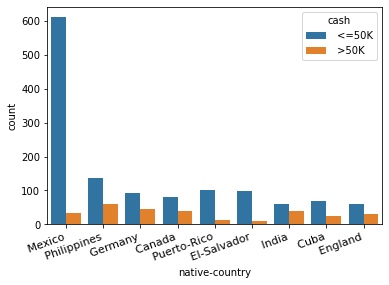

In [15]:
df_train_known = df_train[df_train[col_name] != ' ?']
labels_array = df_train_known[col_name]
sns.countplot(labels_array, order=pd.value_counts(labels_array).iloc[1:10].index, data=df_train_known, hue='cash')
plt.xticks(rotation=20, ha='right', fontsize=11)
plt.savefig('without_us_nat_cntry.png')

In [ ]:
# bar graph of countries
sns.countplot(df_train_cpy1[col_name])

In [ ]:
# create a copy of the original df_train
df_train_cpy1 = df_train.copy(deep=True)

nc_cond = [
    (df_train_cpy1['native-country']==' United-States'),
    (df_train_cpy1['native-country']==' ?'),
    (df_train_cpy1['native-country']!=' United-States')
    ]
nc_vals = ['US', '?', 'Non-US']

# create a new column and use np.select to assign values to it using our lists as arguments
df_train_cpy1['nc_catgry'] = np.select(nc_cond, nc_vals)

# display updated DataFrame
df_train_cpy1.head(2)

In [ ]:
# SELECT ONLY PEOPLE IN 'US'
df_slct_nc = df_train_cpy1[df_train_cpy1['nc_catgry'] != 'UdwdwdS']
sns.displot(df_slct_nc, x='cash')

GROUP UP NATIVE-COUNTRIES INTO CONTINENTS

In [ ]:
col_name = 'native-country'
col_counts = df_train_cpy1[col_name].value_counts()
col_counts_keys = col_counts.keys().tolist()
col_counts_vals = col_counts.values.tolist()
col_counts_keys.remove(' ?')

In [ ]:
import pycountry_convert as pc

tmp_list = []
for cntry in col_counts_keys:
    cntry_ = cntry[1:]
    
    if cntry_ in ['United-States', 'Puerto-Rico', 'El-Salvador', 'England', 'South', 
                  'Dominican-Republic', 'Columbia', 'Hong', 'Trinadad&Tobago', 'Yugoslavia', 
                  'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Holand-Netherlands']:
        continent_name = 'N/A'
    else:
        country_code = pc.country_name_to_country_alpha2(cntry_, cn_name_format="default")
        continent_name = pc.country_alpha2_to_continent_code(country_code)
    
    tmp_list.append(continent_name)
print(tmp_list)

In [ ]:
# create a dictionary mapping country to continent
# col_counts_keys should not have ' ?' in it
cont_map = {}
for itr in range(len(tmp_list)):
    cont_map[col_counts_keys[itr]] = tmp_list[itr]

# fill in the N/A values manually
na_vals_mapping = {
    ' United-States': 'NA',
    ' Puerto-Rico': 'NA',
    ' El-Salvador': 'NA',
    ' England': 'EU',
    ' South': 'NA',  # not sure what south means
    ' Dominican-Republic': 'NA',
    ' Columbia': 'SA',
    ' Hong': 'AS',
    ' Trinadad&Tobago': 'SA',
    ' Yugoslavia': 'EU',
    ' Outlying-US(Guam-USVI-etc)': 'NA',
    ' Scotland': 'EU',
    ' Holand-Netherlands': 'EU'
}
for key in cont_map.keys():
    if (cont_map[key] == 'N/A'):
        cont_map[key] = na_vals_mapping[key]
        
cont_map

In [ ]:
#df_train_cpy1[col_name]
df_train_cpy1['continent'] = df_train_cpy1[col_name].map(cont_map)

In [ ]:
col_name = 'continent'
col_counts = df_train_cpy1[col_name].value_counts()
#col_counts_keys = col_counts.keys().tolist()
#col_counts_vals = col_counts.values.tolist()

print('Column counts:\n' + str(col_counts))
#print('Minimum count: ' + str(min(col_counts_vals)))
#print('Maximum count: ' + str(max(col_counts_vals)))
#print(len(col_counts_keys))

In [ ]:
# bar graph of continents
sns.countplot(df_train_cpy1[col_name])

OTHER INITIAL ANALYSIS WORK

In [16]:
# relation between education number and education
max_education_num = max(df_train['education-num'])
education_num_values = [None]*max_education_num
for itr in range(0, max_education_num):
    education_num_values[itr] = df_train[df_train['education-num'] == itr+1].head(1)['education'].values[0]
print(education_num_values)

[' Preschool', ' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th', ' 10th', ' 11th', ' 12th', ' HS-grad', ' Some-college', ' Assoc-voc', ' Assoc-acdm', ' Bachelors', ' Masters', ' Prof-school', ' Doctorate']


PIE CHART

Minimum count: 1
Maximum count: 29170


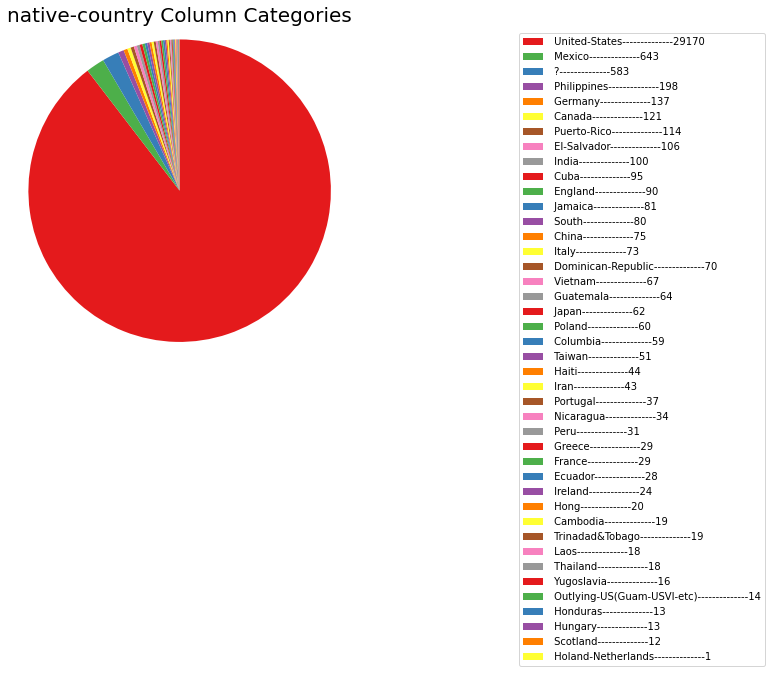

In [56]:
col_name = 'native-country'
col_counts = df_train[col_name].value_counts()
col_counts_keys = col_counts.keys().tolist()
col_counts_vals = col_counts.values.tolist()

# uses education_num_values defined in pre-computation
legend_str_list = [str(i)+"-------"+"-------"+str(j) for i, j in zip(col_counts_keys, col_counts_vals)]

print('Minimum count: ' + str(min(col_counts)))
print('Maximum count: ' + str(max(col_counts)))

plt.figure(figsize=(6,6))
plt.pie(col_counts_vals,
        startangle=90,
        counterclock=False,
        radius=2,
        colors=['#e41a1c','#4daf4a','#377eb8','#984ea3','#ff7f00',
                '#ffff33','#a65628','#f781bf','#999999'],
        textprops={'fontsize': 10})
plt.axis('equal')
plt.legend(legend_str_list, bbox_to_anchor=(1.5,1))
plt.title(col_name+' Column Categories', fontsize = 20)
plt.show()

HISTOGRAM

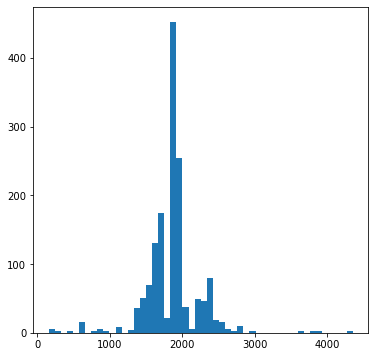

In [18]:
col_name = 'capital-loss'
bins_val = 50

plt.figure(figsize=(6,6))
# removed zero values to get more insight on non-zero gains
if (col_name == 'capital-gain' or col_name == 'capital-loss'):
    df_train_no_zeros = df_train[df_train[col_name]!=0]    
    plt.hist(df_train_no_zeros[col_name], bins=bins_val)
else:
    plt.hist(df_train[col_name], bins=bins_val)
plt.show()

FOCUS ON AGE AND SALARY RELATION

In [19]:
max(df_train['age'])

90

In [32]:
# create a copy of the original df_train
#df_train_cpy = df_train.copy(deep=True)
# AGE: less than 50 as 0 and greater than 50 as 1
min_age = min(df_train['age'])
max_age = max(df_train['age'])
difference_point = 20
age_cond = [
    (df_train_cpy['age']>=min_age) & (df_train_cpy['age']<difference_point),
    (df_train_cpy['age']>=difference_point) & (df_train_cpy['age']<max_age)
    ]
age_vals = ['Adults', 'Seniors']

# create a new column and use np.select to assign values to it using our lists as arguments
df_train_cpy['age_catgry'] = np.select(age_cond, age_vals)

# display updated DataFrame
df_train_cpy.head(2)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,cash,slry_bool,age_catgry
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0,Seniors
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0,Seniors


In [33]:
# counts of <=50k and >50k salary within each age category
adlts_slry_dat = df_train_cpy[df_train_cpy['age_catgry']=='Adults']['slry_bool']
snrs_slry_dat = df_train_cpy[df_train_cpy['age_catgry']=='Seniors']['slry_bool']

print(adlts_slry_dat.value_counts())
print(snrs_slry_dat.value_counts())

0    1655
1       2
Name: slry_bool, dtype: int64
0    23030
1     7831
Name: slry_bool, dtype: int64


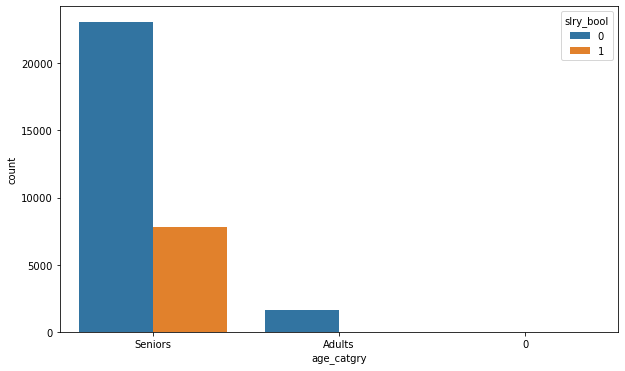

In [34]:
plt.figure(figsize=(10,6))
sns.countplot(x='age_catgry', hue='slry_bool', data=df_train_cpy)